<a href="https://colab.research.google.com/github/DM871/dm871.github.io/blob/master/notebooks/lab_scip_2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Solving MILP Problems in Python - Part 2

## The Diet Example

So far we have written models with embedded data. However, when building
an optimization model, it is typical to separate the optimization model
itself from the data used to create an instance of the model. These two
model ingredients are often stored in completely different files.

There are alternate approaches to providing data to the optimization
model: they can be embedded in the source file, read from an SQL
database (using the Python sqlite3 package), or read them from an Excel
spreadsheet (using the Python xlrd package) and more.

#### Diet Problem

Bob wants to plan a nutritious diet, but he is on a limited budget, so
he wants to spend as little money as possible. His nutritional
requirements are as follows:
```
  ----------------
  2000 Kcal
  55 g protein
  800 mg calcium
  ----------------
```
Bob is considering the following foods with corresponding nutritional
values
```
                Serving Size   Price per serving   Energy (Kcal)   Protein (g)   Calcium (mg)
  ----------- -------------- ------------------- --------------- ------------- --------------
  Oatmeal               28 g                 0.3             110             4              2
  Chicken              100 g                 2.4             205            32             12
  Eggs               2 large                 1.3             160            13             54
  Milk                237 cc                 0.9             160             8            285
  Apple Pie            170 g                   2             420             4             22
  Pork                 260 g                 1.9             260            14             80
```

With the help of Python/SCIP, find the amount of servings of each type
of food in the diet.

We specify the model independently from the data. We could put the model in a file, eg, `dietmodel.py` and the data in another file, eg, `diet1.py`. Make
sure you understand the model and the use of the `quicksum` function also reading the documentation.


In [61]:
%pip install pyscipopt

Looking in indexes: https://pypi.gurobi.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pyscipopt as pso

In [10]:
def solve(categories, minNutrition, maxNutrition, foods, cost, nutritionValues):
    # Model
    m = pso.Model("diet")

    # Create decision variables for the nutrition information,
    # which we limit via bounds
    nutrition = {}
    for c in categories:
        nutrition[c] = m.addVar(lb=minNutrition[c], ub=maxNutrition[c], name=c)

    # Create decision variables for the foods to buy
    buy = {}
    for f in foods:
        buy[f] = m.addVar(obj=cost[f], name=f)

    # The objective is to minimize the costs
    m.setMinimize()

    # Nutrition constraints
    for c in categories:
        m.addCons(
            pso.quicksum(nutritionValues[f, c] * buy[f] for f in foods) == nutrition[c],
            c)

    def printSolution():
        if m.getStatus() == "optimal":
            print('\nCost: %g' % m.getObjVal())
            print('\nBuy:')
            for f in foods:
                if m.getVal(buy[f]) > 0.0001:
                    print('%s %g' % (f, m.getVal(buy[f])))
            print('\nNutrition:')
            for c in categories:
                print('%s %g' % (c, m.getVal(nutrition[c])))
        else:
            print('No solution')

    # Solve
    m.writeProblem("diet.lp")
    m.optimize()
    printSolution()


To arrange the data in Python data structures we use another global function from pyscipopt:
[`multidict`](http://www.gurobi.com/documentation/current/refman/py_python_api_details.html). Here is an example of what it
does:

In [3]:
keys, dict1, dict2 = pso.multidict( {
        'key1': [1, 2],
        'key2': [1, 3],
        'key3': [1, 4] } )
print(keys, dict1, dict2)

['key1', 'key2', 'key3'] {'key1': 1, 'key2': 1, 'key3': 1} {'key1': 2, 'key2': 3, 'key3': 4}


In [8]:
categories, minNutrition, maxNutrition = pso.multidict({
  'Calories': [1800, 2200],
  'Protein':  [91, None],
  'Calcium':   [0, 1779] })

foods, cost = pso.multidict({
	'Oatmeal':           	 0.30,
	'Chicken':		 2.40,
	'Eggs':   	         1.30,
	'Milk':             	 0.90,
	'Apple Pie':           	 2.00,
	'Pork':              	 1.90});

# Nutrition values for the foods
nutritionValues = {
('Oatmeal',           'Calories'  ):	110, 
('Oatmeal',           'Protein' ):	4,    
('Oatmeal',           'Calcium' ):	2,
('Chicken',           'Calories'  ):	205, 
('Chicken',           'Protein' ):	32,    
('Chicken',          'Calcium' ):	12, 
('Eggs',              'Calories'  ):	160,       
('Eggs',              'Protein' ):	13,   
('Eggs',              'Calcium' ):	54, 
('Milk',              'Calories'  ):	160,       
('Milk',             'Protein' ):	8,            
('Milk',              'Calcium' ):	285,   
('Apple Pie',        'Calories'  ):	420, 
('Apple Pie',        'Protein' ):	4,            
('Apple Pie',        'Calcium' ):	22, 
('Pork',              'Calories'  ):	260, 
('Pork',              'Protein' ):	14,           
('Pork',              'Calcium' ):	80 };


If we put the code in the two files, then we could solve from `diet1.py` as follows:
```python
import dietmodel
dietmodel.solve(categories, minNutrition, maxNutrition, foods, cost, nutritionValues)
```

Here it suffices calling:

In [11]:
solve(categories, minNutrition, maxNutrition, foods, cost, nutritionValues)

wrote problem to file /home/marco/Teaching/Courses/DM871/dm871.github.io/notebooks/diet.lp

Cost: 6.825

Buy:
Oatmeal 14.4241
Chicken 1.04074

Nutrition:
Calories 1800
Protein 91
Calcium 41.337
presolving:
(round 1, fast)       3 del vars, 0 del conss, 0 add conss, 8 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 2, fast)       3 del vars, 0 del conss, 0 add conss, 8 chg bounds, 2 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 3, fast)       3 del vars, 0 del conss, 0 add conss, 11 chg bounds, 2 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver found nothing
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present
presolving (4 rounds: 4 fast, 1 medium, 1 exhaustive):
 3 deleted vars, 0 deleted constraints, 0 added constraints, 11 tightened bounds, 0 added holes, 2 changed sides, 0 changed coefficients
 0

#### Your Task

A pill salesman offers Bob Calories, Protein, and Calcium pills to
fulfill his nutritional needs. He needs to estimate the prices of units
of serving, that is, the cost of 1 kcal, the cost of 1 g of protein, the
cost of 1 mg of calcium. He wants to make as much money as possible,
given Bob's constraints. He knows that Bob wants 2200 kcal, 55 g
protein, and 1779 mg calcium. How can we help him in guaranteeing that
he does not make a bad deal?



**Solution:**

The dual seeks to maximize the profit of the salesman. Let $y_i \geq 0$,
$i\in N$ be the prices of the pills.

$$\begin{aligned}
\text{min}\quad &\sum_{j \in F}c_jx_j\\
\sum_{j\in F} a_{ij}x_j&\geq N_{min,i}, \qquad\forall i \in N\\
%\sum_{j\in F}a_{ij}x_{j}&\leq N_{max,i}, \qquad\forall i \in N\\
x_j&\geq 0, \qquad \forall j\in F\\
x_j&\leq F_{max,j}, \qquad \forall j \in F\end{aligned}$$

$$\begin{aligned}
\text{max}\quad &\sum_{i \in F}N_{min,i}y_i\\
\sum_{i\in N} a_{ji}y_i&\leq c_{j}, \qquad\forall j \in F\\
y_i&\geq 0, \qquad \forall i\in N\\\end{aligned}$$

However the values of the dual variables can be determined by the last
tableau of the solution to the primal problem by printing the `Pi`
attribute of the constraints.


# Particular Cases

The two following LP problems lead to two particular cases when solved
by the simplex algorithm. Identify these cases and characterize them,
that is, give indication of which conditions generate them in general.
Then, implement the models in Gurobi Python and observe the behaviour.

$$\begin{array}{rllllllllll}
\mbox{maximize} & 2x_1& +& x_2&\\
    \mbox{subject to} &&&   x_2&  \leq &5&\\
&                    - x_1& +& x_2 &\leq &1& \\
&              x_1, &&x_2&\geq &0& \\
\end{array}$$

$$\begin{array}{rlllllllllll}
\mbox{maximize}& x_1 &+& x_2&\\
    \mbox{subject to} & 5 x_1& +& 10 x_2&  \leq& 60&\\
&                    4 x_1 &+ &4 x_2 &\leq &40& \\
&               x_1, &&x_2&\geq &0& \\
\end{array}$$

# Pathological Cases

This exercise asks you to check the behavior of the solvers on the two
pathological cases:

$$\begin{array}{rlllllllllll}
\mbox{maximize}&&& 4x_2&\\
\mbox{subject to}&&& 2x_2 &\geq& 0\\
& -3x_1& +&4 x_2& \geq &1\\
&       x_1, &&x_2&\geq &0& \\
\end{array}$$

$$\begin{array}{rlllllllllll}
\mbox{maximize}\ \ \   10x_1 -57 x_2 -9x_3-24x_4&\\
    \mbox{subject to}\ \   -0.5x_1+5.5x_2+2.5x_3-9x_4 &\leq 0\\
                                  -0.5 x_1 + 1.5 x_2 +0.5 x_3 -x_4& \leq 0\\
  x_1  &\leq 1&\\
               x_1, x_2, x_3, x_4&\geq 0& \\
\end{array}$$

What happens with the solver? Can you detect which pathological cases
are from the output of the solver? How?


# Shortest Path

Model the shortest path problem as an LP problem. Write the model in
Python using the skeleton below that reads the coordinates of 20 data points.
In this data the source is node 1
and the target is node 20 and we assume that all connections between vertices are available except the direct link from source to target.

Model the problem in LP and solve it with PySCIPOpt. Check the
correctness of your solution with the help of the visualization in the
template below.


It may be worth looking at the example on the [transportation problem](https://scipopt.github.io/PySCIPOpt/docs/html/transp__nofn_8py_source.html).




In [73]:
import math
import pandas as pd
import pyscipopt as pso


url = 'https://dm871.github.io/assets/20points.csv'
df = pd.read_csv(url, sep='\t', header=None, names=('label','x','y'))
points = {v: (x,y) for v,x,y in df.itertuples(index=False)}


source = 1
target = 20

# calculate Euclidean distance and round-towards-zero (truncate)

def distance(points, i, j):
    dx = points[i][0] - points[j][0]
    dy = points[i][1] - points[j][1]
    return math.floor(math.sqrt(dx*dx + dy*dy))

m=pso.Model()


##############################################################################
V = points.keys()
A = [(i,j) for i in V for j in V if i!=j]
A.remove((source,target))

# Begin: Change here

##############################################################################
# Create variables
##############################################################################
x = {(v,u): m.addVar(A,obj=[distance(points,i,j) for i,j in A],vtype="C",name='x')}


##############################################################################
# Post the constraints
##############################################################################
def balance(v):
    if v==source:
        return 1
    if v==target:
        return -1
    return 0

for v in V:
    m.addConstr(pso.quicksum(x[v,u] for v,u in A.select(v,'*'))-gb.quicksum(x[u,v] for u,v in A.select('*',v))==balance(v))


# End: Change here
##############################################################################


m.write("sp.lp")
#m.display()


In [68]:
m.optimize()
solution = m.getAttr('x', x)

selected = [(i,j) for i,j in A if solution[i,j] > 0.5]
print(filter(lambda x: x[1]>0, solution.iteritems()))

print( map(lambda i, j: distance(points, i, j), A))

print('Optimal path: %s' % str(selected))
print('Optimal cost: %g' % m.objVal)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 20 rows, 379 columns and 758 nonzeros
Model fingerprint: 0xcf50fb07
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 20 rows, 379 columns, 758 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.000000e+00   0.000000e+00      0s
      16    5.3110000e+03   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.01 seconds
Optimal objective  5.311000000e+03
Optimal path: [(1, 10), (10, 20)]
Optimal cost: 5311


In [69]:
%matplotlib inline

{1: (287, 4582), 2: (392, 4764), 3: (450, 2927), 4: (722, 761), 5: (976, 1858), 6: (983, 1197), 7: (997, 3687), 8: (1400, 421), 9: (1710, 2522), 10: (1732, 3055), 11: (2712, 2296), 12: (2997, 1214), 13: (3121, 2473), 14: (3172, 917), 15: (3283, 4810), 16: (3317, 748), 17: (3521, 4748), 18: (3535, 1563), 19: (3887, 1388), 20: (3928, 714)} [(1, 10), (10, 20)]


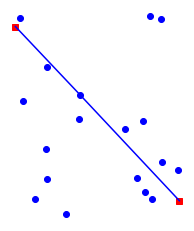

In [70]:

import matplotlib.pyplot as plt
def plot_path(points, path, style='bo-'):
    "Plot lines to connect a series of points."
    plt.plot([p[1][0] for p in points.items()], [p[1][1] for p in points.items()], 'bo')
    plt.plot([points[source][0],points[target][0]],[points[source][1],points[target][1]], 'rs')
    plt.plot([(points[p[0]][0],points[p[1]][0]) for p in path], 
             [(points[p[0]][1],points[p[1]][1]) for p in path], 'b-')
    plt.axis('scaled'); plt.axis('off')
    plt.show()

print(points, selected)
plot_path(points, selected)